In [ ]:
#!pip install cvxopt
#!pip install libsvm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import pickle
import cvxopt
from scipy.spatial.distance import pdist,squareform,cdist
from sklearn.svm import SVC
from sklearn import metrics
import time

training_file = "drive/MyDrive/part2_data/train_data.pickle" #str(sys.argv[1])
testing_file  = "drive/MyDrive/part2_data/test_data.pickle"  #str(sys.argv[2])
EPSILON = 1e-4
gamma = 0.001
C = 1.0

In [ ]:
def readData(file_name):
    file = open(file_name,"rb")
    fileDict = pickle.load(file)
    
    X = []
    Y = []

    for idx in range(len(fileDict["data"])):
        if fileDict["labels"][idx] == 1 or fileDict["labels"][idx] == 2:
            X.append(fileDict["data"][idx].reshape(-1))
            Y.append(fileDict["labels"][idx])

    X = np.array(X)
    Y = np.array(Y)
    
    X = X/255
    Y = np.where(Y==2,1,-1)
    
    X = X.astype('float64')
    Y = Y.astype('float64')
    
    return X,Y

X,Y = readData(training_file)
X_test,Y_test = readData(testing_file)

In [ ]:
def svm_cvxopt(X,Y,isLinear,C,gamma):
    
    start_time = time.time()

    if isLinear:
        tempProd0 = np.matmul(X,X.T)
        tempProd = np.matmul(Y,Y.T)*tempProd0
        P = cvxopt.matrix(tempProd)
    else:
        tempProd0 = gaussian_kernel(X,X)
        P = cvxopt.matrix(np.matmul(Y,Y.T)*tempProd0)
    
    tempG = np.identity(Y.shape[0])
    G = cvxopt.matrix(np.append(tempG,-1*tempG,axis = 0))
    
    Q = cvxopt.matrix(-1*np.ones((Y.shape[0],1)))
    
    A = cvxopt.matrix(Y.T)
    
    tempH = np.ones((Y.shape[0],1))
    H = cvxopt.matrix(np.append(C * tempH, 0 * tempH, axis=0))
    
    B = cvxopt.matrix(0.0)
    
    sol = cvxopt.solvers.qp(P, Q, G, H, A, B, options={'show_progress': False})
    
    tempX = np.array(sol['x'])
    alpha = np.reshape(tempX, (Y.shape[0],1))
    
    indices = []
    
    for idx in range(Y.shape[0]):
        if alpha[idx] > EPSILON:
            indices.append(idx)

    if isLinear:
      inner_product = np.sum(alpha*Y*tempProd0,0)
    else:
      inner_product = np.sum(alpha*Y*gaussian_kernel(X,X),0)

    M = -float("inf")
    M_index = -1
    m = float("inf")
    m_index = -1

    for idx in range(Y.shape[0]):
        val = -float("inf") if Y[idx]==1 else inner_product[idx]
        if M<val:
          M = val
          M_index = idx
        
        val = float("inf") if Y[idx]==-1 else inner_product[idx]
        if m>val:
          m = val
          m_index = idx
    
    b = -1*(inner_product[M_index]+inner_product[m_index])/2
    
    print("Total training time: "+str(time.time()-start_time))
    return alpha,indices,b

def LinearAccuracy(X,Y,W,b):
    pred = np.where((np.matmul(X,W)+b)>=0,1,-1)
    return (sum(pred==Y)[0]*100)/Y.shape[0]

def gaussian_kernel(x, y):
    return np.exp(-1*gamma * cdist(x, y, "sqeuclidean"))

def eval(x_test, y_test,X_train,Y_train,alpha,b,indices,gamma):
    y_hat = (np.sum(alpha * Y_train * gaussian_kernel(X_train, x_test),axis=0,keepdims=True).T + b)
    return np.sign(y_hat)

def GaussAccuracy(X_test,Y_test,X_train,Y_train,alpha,b,indices,gamma):
    final_pred = eval(X_test,Y_test,X_train[indices],Y_train[indices],alpha[indices],b,indices,gamma)

    return (sum(final_pred==Y_test)[0]*100)/Y_test.shape[0]

In [ ]:
#test = pdist(X,'sqeuclidean')
#print(test.shape)
#print(squareform(test).shape)

In [ ]:
alpha,indices,b = svm_cvxopt(X,Y,True,C,None)
W = np.matmul((Y*X).T,alpha)

Total training time: 82.79982471466064


(3072, 1)


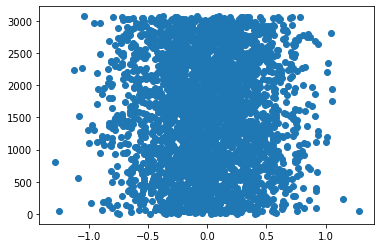

In [ ]:
print(W.shape)
plt.scatter(W,range(W.shape[0]))
plt.savefig("2a_weight_representation.png")
plt.show()

In [ ]:
print("For Linear SVM")
print("Total support vectors: "+str(len(indices)))
print("Total data points: "+str(Y.shape[0]))
print("Training accuracy: "+str(LinearAccuracy(X,Y,W,b)))
print("Testing accuracy: "+str(LinearAccuracy(X_test,Y_test,W,b)))


For Linear SVM
Total support vectors: 1543
Total data points: 4000
Training accuracy: 94.225
Testing accuracy: 77.25


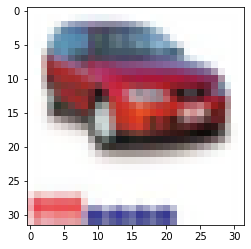

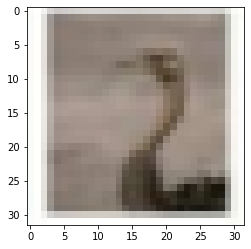

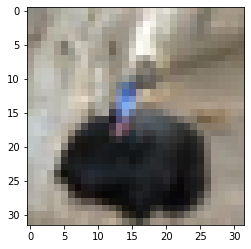

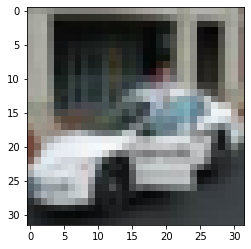

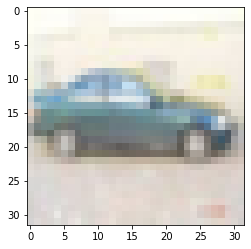

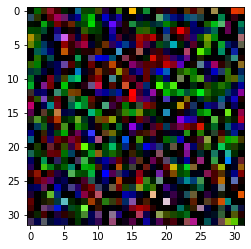

In [ ]:
def show_img(vector_img,index):
  img = vector_img.reshape((32,32,3))
  plt.imshow(img, interpolation='none')
  plt.savefig("drive/MyDrive/part2_data/2d_img_"+str(index))
  plt.show()

def match(sv1,sv2):
  count = 0
  for vec in sv1:
    if vec in sv2:
      count += 1
  return count

sorted_alpha = np.flip(np.argsort(alpha,axis = 0))
for idx in range(5):
  show_img(X[sorted_alpha[idx]],idx)
show_img(W,"weight")

In [ ]:
alphaG,indicesG,bG = svm_cvxopt(X,Y,False,C,gamma)

Total training time: 142.08444595336914


In [ ]:
print("For Gaussian SVM")
print("Total support vectors: "+str(len(indicesG)))
print("Total data points: "+str(Y.shape[0]))
print("Training accuracy: "+str(GaussAccuracy(X,Y,X,Y,alphaG,bG,indicesG,gamma)))
print("Testing accuracy: "+str(GaussAccuracy(X_test,Y_test,X,Y,alphaG,bG,indicesG,gamma)))

For Gaussian SVM
Total support vectors: 1872
Total data points: 4000
Training accuracy: 84.2
Testing accuracy: 82.1


Number of matching SV in Linear and Kernal CVXOPT: 1161


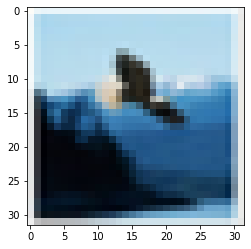

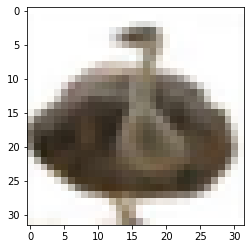

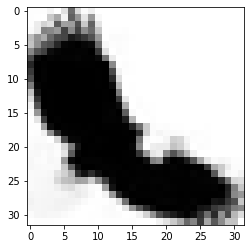

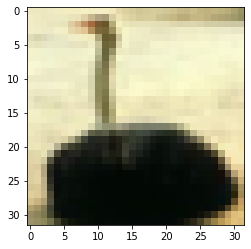

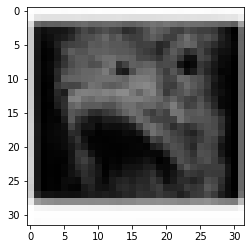

In [ ]:
print("Number of matching SV in Linear and Kernal CVXOPT: "+str(match(indices,indicesG)))

sorted_alpha = np.flip(np.argsort(alphaG,axis = 0))
for idx in range(5):
  show_img(X[sorted_alpha[idx]],idx)

In [ ]:
def sklearn_svm(X,Y,X_test,Y_test,isLinear,C,gamma):

    if isLinear:
        print("Training the linear classifer")
        clf = SVC(kernel='linear', C=C)
    else:
        print("Training the gaussian classifer")
        clf = SVC(kernel='rbf', gamma=gamma, C=C)
    
    start_time = time.time()
    clf.fit(X,Y)
    print("Total training time: "+str(time.time()-start_time))
    
    pred = clf.predict(X)

    print("Number of support vectors used : "+str(np.sum(clf.n_support_)))
    print("Training accuracy: "+str(metrics.accuracy_score(pred,Y)))

    test_pred = clf.predict(X_test)
    print("Testing accuracy: "+str(metrics.accuracy_score(test_pred,Y_test)))

    if(isLinear and True):
      #print("The values of w and b in case of linear are: ")
      #print(clf.coef_[0])
      #print(clf.intercept_[0])

      return clf.support_,clf.coef_[0],clf.intercept_[0]
    
    return clf.support_,None,None

In [15]:
sv1,svW,svB = sklearn_svm(X,Y,X_test,Y_test,True,C,gamma)
print("\n\n")
sv2,_,_ = sklearn_svm(X,Y,X_test,Y_test,False,C,gamma)
print("Number of common support vectors: "+str(match(sv1,indices)))


Training the linear classifer


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total training time: 30.42832088470459
Number of support vectors used : 1541
Training accuracy: 0.9485
Testing accuracy: 0.7805



Training the gaussian classifer


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Total training time: 19.347395181655884
Number of support vectors used : 1865
Training accuracy: 0.89325
Testing accuracy: 0.874
Number of common support vectors: 1541


In [16]:
print(((svW - W) ** 2).mean() ** 0.5)
print(abs(b-svB))

0.5258884893739982
0.42707731250488


In [17]:
print("Number of common support vectors Gauss: "+str(match(sv2,indicesG)))

Number of common support vectors Gauss: 1865
